In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time

import qiskit
import qiskit as qiskit
import qiskit.quantum_info as qi
# Tomography functions
from qiskit.providers.aer.noise import NoiseModel
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import DensityMatrix

from qiskit import *
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.visualization import *

# Loading your IBM Quantum account(s)
IBMQ.save_account(
    '280beccbee94456a161a6cbc217e1366bc278bf60e22bd30281fa0ca5bec6e50897278ef818f3c53f6700e04b9ed32ea364195044413b7e02836a79d886b03d9',
    overwrite=True)
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-research')

/tmp/ipykernel_1965/4033521064.py:10: DeprecationWarning: The QuantumCircuit.u3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use QuantumCircuit.u instead, which acts identically. Alternatively, you can decompose u3 in terms of QuantumCircuit.p and QuantumCircuit.sx: u3(ϴ,φ,λ) = p(φ+π) sx p(ϴ+π) sx p(λ) (2 pulses on hardware).
  circuit.u3(3.33,2.8,3.72,2)


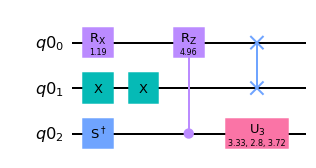

In [4]:
from qiskit.circuit.library.standard_gates import CRZGate
qr = QuantumRegister(3)
circuit = QuantumCircuit(qr)
circuit.rx(1.19, 0)
circuit.x(1)
circuit.sdg(2)
circuit.x(1)
circuit.crz(4.96,2,0)
circuit.swap(0,1)
circuit.u3(3.33,2.8,3.72,2)
circuit.draw(output='mpl')

In [5]:
vector = qi.Statevector.from_instruction(circuit)
tomo_circuit = state_tomography_circuits(circuit, circuit.qubits);

/home/david/python-inter/lib/python3.9/site-packages/qiskit/ignis/verification/tomography/basis/circuits.py:468: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  prep += circuit
/home/david/python-inter/lib/python3.9/site-packages/qiskit/circuit/quantumcircuit.py:942: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  return self.extend(rhs)
/home/david/python-inter/lib/python3.9/site-packages/qiskit/ignis/verification/tomography/basis/circuits.py:478: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  circ = prep + meas
/home/davi

In [6]:
#Simulator
name = 'ibmq_jakarta'
results = []
backend = provider.get_backend(name)
noise_model = NoiseModel.from_backend(backend)
full_layout = [0, 1, 3, 5, 4, 2, 6]
# Get coupling map from backend
coupling_map = backend.configuration().coupling_map

# Get basis gates from noise model
basis_gates = noise_model.basis_gates
qcomp = Aer.get_backend("qasm_simulator")
layout = full_layout[:circuit.num_qubits]
result = qiskit.execute(tomo_circuit, Aer.get_backend('qasm_simulator'),
                                  coupling_map=coupling_map,
                                  basis_gates=basis_gates,
                                  noise_model=noise_model, initial_layout=layout, shots=8000).result()


In [7]:
from Tomography import tomography

tomo_fitter_bell = StateTomographyFitter(result, tomo_circuit).fit(method='lstsq')
densitie = DensityMatrix(tomo_fitter_bell)
fidelity = tomography.calc_fidelity(DensityMatrix(tomo_fitter_bell), vector)
purity = tomography.calc_purity(DensityMatrix(tomo_fitter_bell))

print(purity,fidelity)

/home/david/python-inter/lib/python3.9/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')


(0.8005165220413955+3.4981092607661396e-19j) 0.7930887450083005


In [8]:
from numpy.linalg import linalg

fixed_purities = 0

# Extracting the density matrix from the state tomography result
state_vector = qi.Statevector.from_instruction(circuit)
theo_matrix = DensityMatrix(state_vector)
theo_eig = linalg.eig(theo_matrix.data)
theo_eig = (theo_eig[0], theo_eig[1].T)

# Getting the most significant eigenvalue and eigenvector
max_val_theo = 0
index = 0
i = 0
for val in theo_eig[0]:
    if np.absolute(val) > np.absolute(max_val_theo):
        index = i
        max_val_theo = val
    i += 1
theo_vector = theo_eig[1][index]

# Real Vector
real_matrix = densitie
real_eig = np.linalg.eig(real_matrix)
real_eig = (real_eig[0], real_eig[1].T)

# Getting the most significant eigenvalue and eigenvector
max_val_real = 0
index = 0
i = 0
for val in real_eig[0]:
    if np.absolute(val) > np.absolute(max_val_real):
        index = i
        max_val_real = val
    i += 1
real_vector = real_eig[1][index]
real_eignval = real_eig[0][index]


dot = np.abs(np.dot(theo_vector, real_vector))**2
print("Number of qubits: ", 3)
print("Vector dot: ", dot)
print("Eigenvalue", real_eignval)
print("Purity: ", np.absolute(purity))
print("Fidelity: ", np.absolute(fidelity))

print("___")
fixed_purity = np.absolute(purity) * (dot**2)
print("Fixed purity: ", fixed_purity)
print("_____________")

Number of qubits:  3
Vector dot:  0.1618841060255396
Eigenvalue (0.8920316705808546-8.129577340586475e-18j)
Purity:  0.8005165220413955
Fidelity:  0.7930887450083005
___
Fixed purity:  0.020978707243121824
_____________


In [9]:
vector.draw('latex')

<IPython.core.display.Latex object>

In [10]:
for i in range(len(real_eig[0])):
    print(np.abs(real_eig[0][i]), ": ", real_eig[1][i])

0.8920316705808546 :  [0.08166173+2.11453099e-02j 0.00369701+4.00418009e-04j
 0.01342131-5.07457773e-02j 0.00620862-3.00519757e-03j
 0.84230379+0.00000000e+00j 0.0083024 +7.19324880e-03j
 0.01597165-5.29237584e-01j 0.00699666-8.64542444e-03j]
0.05795587563967855 :  [ 1.75743115e-02-0.03714945j  6.39648221e-04-0.0070616j
  1.01284095e-01+0.01146162j -3.97241140e-02+0.0134572j
 -1.62321795e-02-0.52562341j  4.01187086e-02-0.08084613j
  8.35505050e-01+0.j         -5.36942499e-02+0.02170324j]
0.03599484611449121 :  [ 0.81648671+0.j         -0.01275175+0.04567382j -0.00232337-0.49272669j
 -0.01215176+0.01717051j -0.05777497+0.01111823j -0.16352736+0.01151963j
  0.01858946+0.08198773j  0.22462703+0.00359769j]
0.011767240282474313 :  [-0.04656557+0.07422549j  0.08937787+0.0889102j   0.08669816-0.29196505j
 -0.03901828-0.08865234j -0.0535017 +0.01165499j  0.82928009+0.j
 -0.01646037-0.03755355j  0.13231938-0.4054548j ]
0.0016292836888732658 :  [ 0.03757017-0.39759323j -0.15193303+0.1432371j   0

In [11]:
densitie.draw('latex')

<IPython.core.display.Latex object>

In [12]:
theo_matrix.draw('latex')

<IPython.core.display.Latex object>

In [13]:
sum = 0
for i, j in zip(range(densitie.dim),range(densitie.dim)):
    sum += (densitie.data[i,j] - theo_matrix.data[i,j])**2

print("Distance: ", sum)

Distance:  (0.00221304343431349+0j)
